# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


Requested tensorflow-gpu from https://files.pythonhosted.org/packages/8a/45/fa31ced1db38f9424f262dfbf35747fe5378b5c808cecb373c8cb8e515d3/tensorflow-gpu-2.12.0.tar.gz has invalid metadata: Expected end or semicolon (after name and no valid version specifier)
    python_version>"3.7"
                  ^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [1]:
!labelme

2024-10-12 17:02:30,261 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\6756a\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [14]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [15]:
images.as_numpy_iterator().next()

b'data\\images\\9ac3c5ab-3508-11ef-a1ef-bcf171ac7082.jpg'

In [16]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [17]:
images = images.map(load_image)

In [18]:
images.as_numpy_iterator().next()

array([[[ 26,  25,  23],
        [ 29,  28,  26],
        [ 24,  22,  23],
        ...,
        [ 97, 109,  99],
        [ 94, 106,  96],
        [ 92, 104,  94]],

       [[ 24,  23,  21],
        [ 27,  26,  24],
        [ 23,  21,  22],
        ...,
        [ 96, 108,  98],
        [ 96, 108,  98],
        [ 97, 109,  99]],

       [[ 21,  21,  21],
        [ 23,  23,  23],
        [ 22,  22,  22],
        ...,
        [ 95, 105,  97],
        [ 96, 107,  99],
        [ 99, 110, 102]],

       ...,

       [[ 55,  69,  72],
        [ 57,  71,  74],
        [ 58,  72,  75],
        ...,
        [118, 122, 123],
        [116, 120, 121],
        [115, 119, 120]],

       [[ 57,  68,  72],
        [ 58,  69,  73],
        [ 59,  70,  74],
        ...,
        [122, 126, 127],
        [122, 126, 127],
        [122, 126, 127]],

       [[ 56,  67,  71],
        [ 57,  68,  72],
        [ 58,  69,  73],
        ...,
        [120, 124, 125],
        [121, 125, 126],
        [121, 125, 126]]

In [19]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [20]:
image_generator = images.batch(4).as_numpy_iterator()

In [21]:
plot_images = image_generator.next()

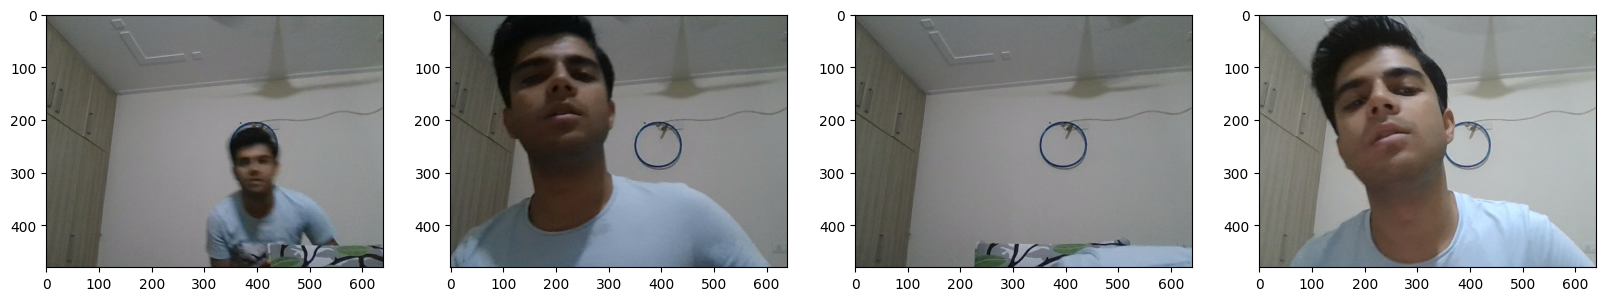

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [23]:
90*.7 # 63 to train

62.99999999999999

In [24]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [25]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [5]:
import albumentations as alb

In [27]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [2]:
img = cv2.imread(os.path.join('data','train', 'images','7cdf269d-3508-11ef-8a56-bcf171ac7082.jpg'))

NameError: name 'cv2' is not defined

In [3]:
with open(os.path.join('data', 'train', 'labels', '7cdf269d-3508-11ef-8a56-bcf171ac7082.json'), 'r') as f:
    label = json.load(f)

NameError: name 'os' is not defined

In [35]:
label['shapes'][0]['points']

[[213.13725490196077, 143.1045751633987],
 [391.24183006535947, 380.359477124183]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [36]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [37]:
coords

[213.13725490196077, 143.1045751633987, 391.24183006535947, 380.359477124183]

In [38]:
coords = list(np.divide(coords, [640,480,640,480]))

In [39]:
coords

[0.3330269607843137,
 0.2981345315904139,
 0.6113153594771241,
 0.7924155773420479]

### 4.4 Apply Augmentations and View Results

In [40]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['human face'])

In [41]:
augmented['bboxes'][0][2:]

(0.6863616557734205, 0.7197676107480029)

In [42]:
augmented['bboxes']

[(0.2905737109658679,
  0.19253449527959332,
  0.6863616557734205,
  0.7197676107480029)]

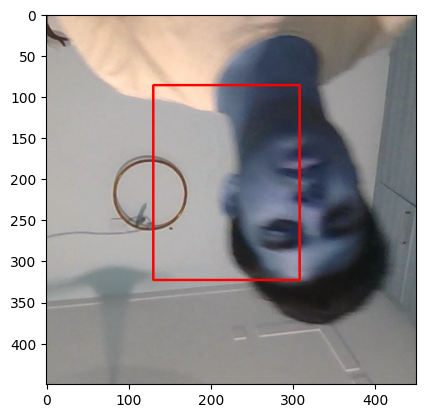

In [43]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [44]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [45]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [46]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [47]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [48]:
train_images.as_numpy_iterator().next()

array([[[0.4696691 , 0.4461397 , 0.30496323],
        [0.4958946 , 0.4723652 , 0.33180147],
        [0.48921567, 0.47058824, 0.32990196],
        ...,
        [0.5367647 , 0.5514706 , 0.4362745 ],
        [0.5352941 , 0.5470588 , 0.43590686],
        [0.5307598 , 0.5458946 , 0.4372549 ]],

       [[0.4759804 , 0.452451  , 0.3112745 ],
        [0.50147057, 0.4779412 , 0.3377451 ],
        [0.49068627, 0.46715686, 0.33382353],
        ...,
        [0.5564338 , 0.5721201 , 0.46721813],
        [0.5469363 , 0.5636029 , 0.4582108 ],
        [0.5818015 , 0.5978554 , 0.49178922]],

       [[0.4841299 , 0.4606005 , 0.31942403],
        [0.5018995 , 0.4783701 , 0.34503677],
        [0.49803922, 0.4745098 , 0.34117648],
        ...,
        [0.61672795, 0.64025736, 0.5382966 ],
        [0.61360294, 0.6302696 , 0.5317402 ],
        [0.57346815, 0.5891544 , 0.49540442]],

       ...,

       [[0.53707105, 0.6351103 , 0.6507966 ],
        [0.5367647 , 0.63480395, 0.6504902 ],
        [0.53719366, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [49]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [50]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.10016, 0.154  , 0.6113 , 0.679  ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [54]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7560, 7560, 1680, 1680, 1560, 1560)

### 7.2 Create Final Datasets (Images/Labels)

In [55]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [56]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [57]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [58]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1224 , 0.3076 , 0.634  , 0.8325 ],
        [0.     , 0.1035 , 0.4817 , 0.633  ],
        [0.8306 , 0.     , 1.     , 0.1694 ],
        [0.51   , 0.3167 , 0.8076 , 0.6406 ],
        [0.2952 , 0.05466, 0.6953 , 0.3765 ],
        [0.1482 , 0.57   , 0.427  , 0.819  ],
        [0.224  , 0.1489 , 0.616  , 0.5845 ],
        [0.     , 0.09436, 0.1284 , 0.65   ]], dtype=float16))

### 7.3 View Images and Annotations

In [59]:
data_samples = train.as_numpy_iterator()

In [60]:
res = data_samples.next()

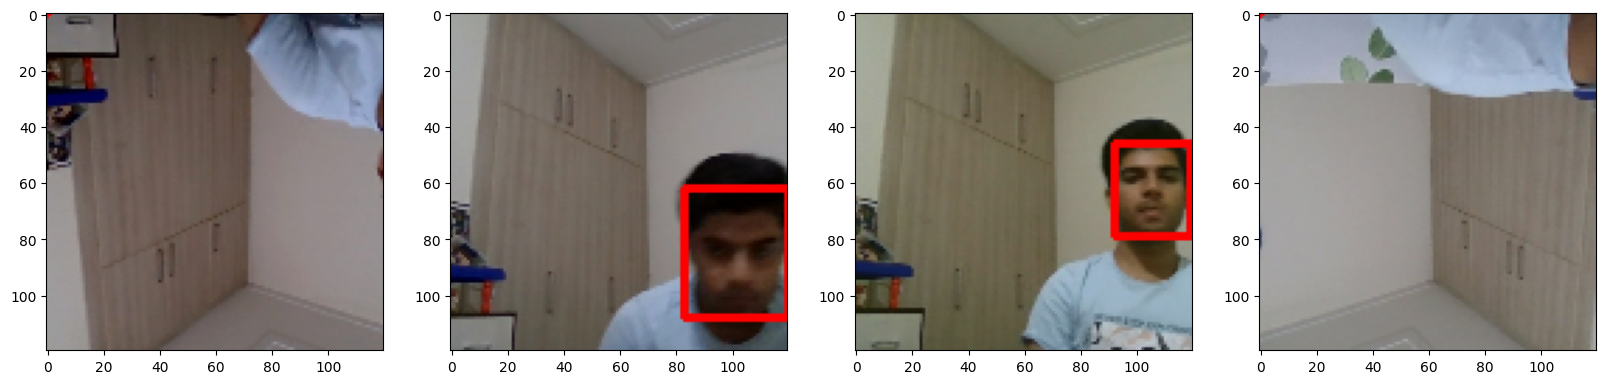

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = res[0][idx].copy()  # Create a writable copy of the image
    sample_coords = res[1][1][idx]
    
    # Calculate the rectangle coordinates
    start_point = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
    end_point = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))
    
    # Draw the rectangle
    cv2.rectangle(sample_image, start_point, end_point, (255, 0, 0), 2)

    ax[idx].imshow(sample_image)
plt.show()


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [63]:
vgg = VGG16(include_top=False)

In [64]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [11]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [66]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4128 , 0.1255 , 0.906  , 0.6997 ],
        [0.413  , 0.2153 , 0.6978 , 0.589  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2025 , 0.568  , 0.6025 , 0.8896 ],
        [0.3535 , 0.3704 , 0.759  , 0.8022 ],
        [0.11584, 0.1548 , 0.5117 , 0.682  ],
        [0.6274 , 0.3284 , 0.9253 , 0.6523 ],
        [0.10077, 0.     , 0.411  , 0.1236 ]], dtype=float16))

### 8.4 Test out Neural Network

In [12]:
facetracker = build_model()

In [13]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
vgg.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
X, y = train.as_numpy_iterator().next()

In [71]:
X.shape

(8, 120, 120, 3)

In [72]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


In [73]:
classes, coords

(array([[0.36994162],
        [0.34910154],
        [0.38649875],
        [0.39749005],
        [0.3648181 ],
        [0.4672991 ],
        [0.36693397],
        [0.38034084]], dtype=float32),
 array([[0.37673494, 0.43082288, 0.52827835, 0.43180737],
        [0.50067294, 0.4774134 , 0.4869603 , 0.38115102],
        [0.39691752, 0.44204882, 0.4320517 , 0.31883642],
        [0.44835934, 0.412918  , 0.58159137, 0.36692014],
        [0.38106632, 0.3887504 , 0.566522  , 0.42764783],
        [0.38329655, 0.33579573, 0.5560589 , 0.4599439 ],
        [0.3762697 , 0.35885268, 0.5513354 , 0.43610588],
        [0.4266803 , 0.46209598, 0.45426166, 0.43378457]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [74]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [75]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

C:\Users\6756a\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [76]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [77]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [78]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.229823>

In [79]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.87437>

In [80]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.229823>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [14]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    @tf.function  # Decorate train_step with @tf.function
    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            try:
                classes, coords = self.model(X, training=True)

                # Ensure y[0] has a defined rank (handle potential reshaping)
                y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
                # Check your data format and reshape accordingly

                # Ensure classes has a defined rank (check model output shape)
                # ... (reshape classes if necessary based on your model's output)

                batch_classloss = self.closs(y_0, classes)
                batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
                total_loss = batch_localizationloss + 0.5 * batch_classloss

            except tf.errors.InvalidArgumentError as e:
                # Handle the case where y[0] might have a batch size of zero (optional)
                if 'Input tensors must be of size at least 1' in str(e):
                    return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
                else:
                    raise e  # Re-raise other errors

            grad = tape.gradient(total_loss, self.model.trainable_variables)
            self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch
        classes, coords = self.model(X, training=False)

        # Ensure y[0] has a defined rank (handle potential reshaping)
        y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
        # Check your data format and reshape accordingly

        # Ensure classes has a defined rank (check model output shape)
        # ... (reshape classes if necessary based on your model's output)

        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [15]:
model = FaceTracker(facetracker)

In [16]:
model.compile(opt, classloss, regressloss)

NameError: name 'opt' is not defined

### 10.2 Train

In [84]:
logdir='logs'

In [85]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [86]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 968s 1s/step - class_loss: 0.0811 - regress_loss: 0.2837 - total_loss: 0.3243 - val_class_loss: 0.0015 - val_regress_loss: 0.1048 - val_total_loss: 0.1056
Epoch 2/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 1020s 1s/step - class_loss: 0.0331 - regress_loss: 0.1107 - total_loss: 0.1272 - val_class_loss: 0.0081 - val_regress_loss: 0.0981 - val_total_loss: 0.1021
Epoch 3/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 1046s 1s/step - class_loss: 0.0169 - regress_loss: 0.0620 - total_loss: 0.0705 - val_class_loss: 0.0392 - val_regress_loss: 0.2570 - val_total_loss: 0.2766
Epoch 4/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 1031s 1s/step - class_loss: 0.0161 - regress_loss: 0.0614 - total_loss: 0.0695 - val_class_loss: 0.0021 - val_regress_loss: 0.0821 - val_total_loss: 0.0831
Epoch 5/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 2858s 3s/step - class_loss: 0.0229 - regress_loss: 0.0712 - total_loss: 0.0826 - val_class_loss: 0.0025 - val_regress_loss: 0.0393 - val_total_loss: 0.0405
Epoch 6/10
945/945 ━━

### 10.3 Plot Performance

In [87]:
hist.history

{'class_loss': [0.08882077783346176,
  0.00038921512896195054,
  0.0013532607117667794,
  0.17315414547920227,
  0.0025756098330020905,
  0.000179264709004201,
  0.003332461230456829,
  0.0004582091060001403,
  0.00048177834833040833,
  0.0016062846407294273],
 'regress_loss': [0.42413607239723206,
  0.022043362259864807,
  0.1294894963502884,
  0.4091039001941681,
  0.0375649631023407,
  0.015979662537574768,
  0.020971093326807022,
  0.029331393539905548,
  0.009552210569381714,
  0.006364829372614622],
 'total_loss': [0.46854645013809204,
  0.02223796956241131,
  0.13016612827777863,
  0.4956809878349304,
  0.038852766156196594,
  0.01606929488480091,
  0.022637324407696724,
  0.029560498893260956,
  0.009793099947273731,
  0.007167971692979336],
 'val_class_loss': [0.0015289693837985396,
  0.008072758093476295,
  0.039241403341293335,
  0.002138514071702957,
  0.0024579577147960663,
  0.0009772779885679483,
  6.772733468096703e-05,
  0.0003065349883399904,
  0.001847841078415513,
 

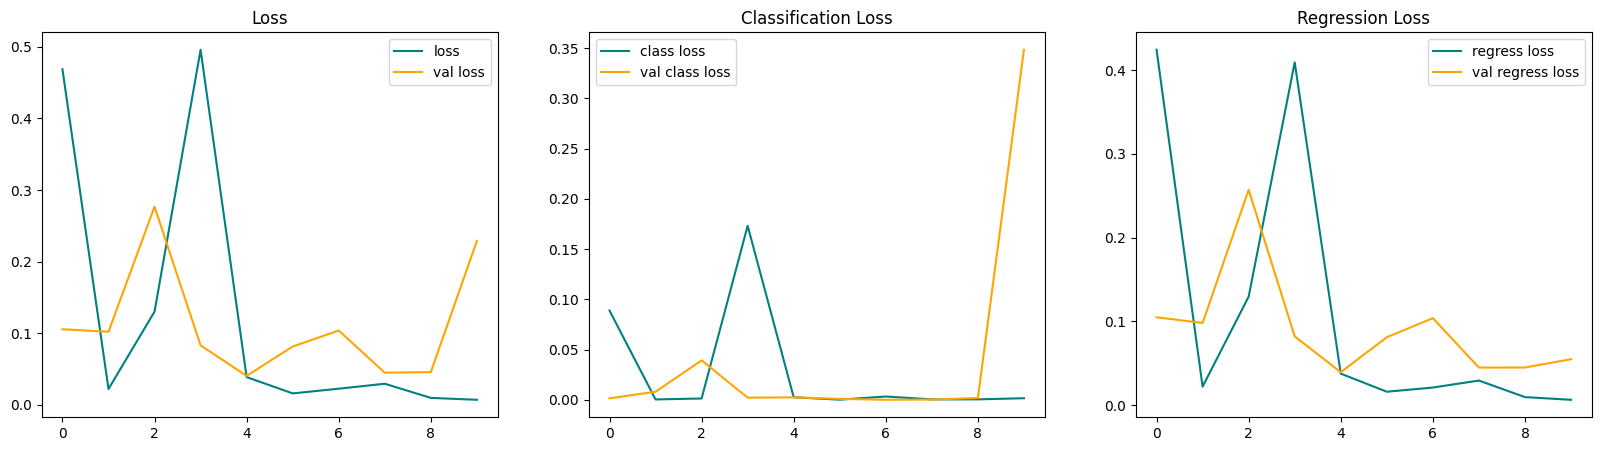

In [88]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [89]:
test_data = test.as_numpy_iterator()

In [90]:
test_sample = test_data.next()

In [91]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


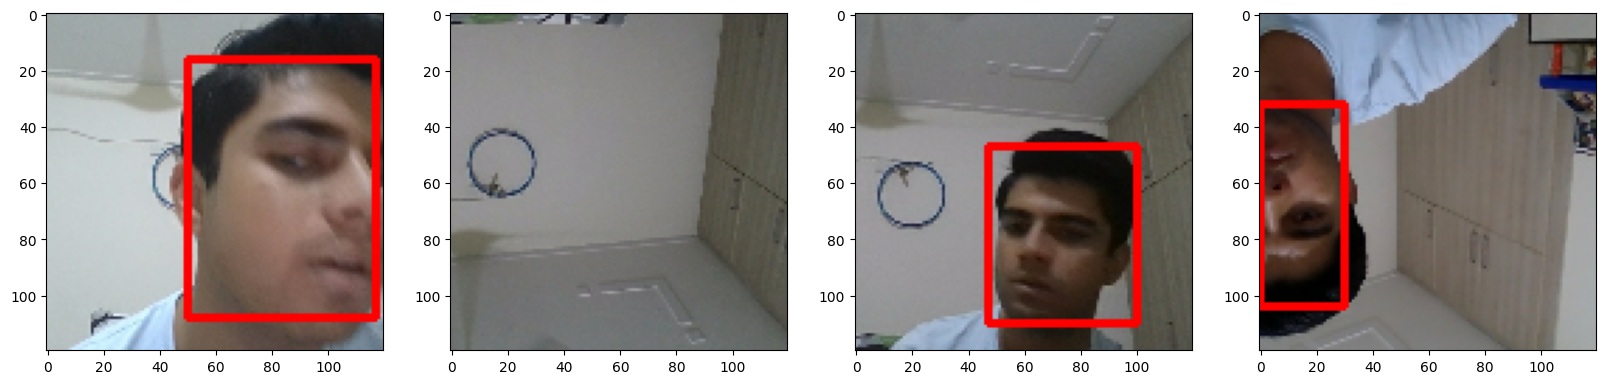

In [92]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    # Create a writable copy of the sample image
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(
            sample_image,
            tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
            (255, 0, 0),
            2
        )

    ax[idx].imshow(sample_image)

plt.show()


### 11.2 Save the Model

In [2]:
from tensorflow.keras.models import load_model

In [97]:
facetracker.save('facetracker.h5')

In [3]:
facetracker = load_model('facetracker.h5')

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 11.3 Real Time Detection

In [10]:
import cv2

cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Human Face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1473: error: (-27:Null pointer) NULL window: 'EyeTrack' in function 'cvResizeWindow'
